# Milestone 1: Data exploration 

For the purpose of the Milstone 2, this notebook aims to cover the data exploration needed to define our project.

In [17]:
# Library
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset 
from src.scripts.load_and_save import load_data

df_bindingDB = load_data()
df_bindingDB.head()


/Users/barbaragrosjean/Desktop/ada-2024-project-laambada/src/scripts/load_and_save.py:11: DtypeWarning: Columns (8,9,10,11,12,13,15,17,20,21,22,23,27,28,32,33,35,36,45,46,47,48,50,51,52,53,54,55,57,58,59,60,62,63,64,65,66,67,69,70,71,72,74,75,76,77,78,79,81,82,83,86,87,88,89,90,91,93,94,95,98,99,100,101,102,103,105,106,107,110,111,112,113,114,115,117,118,119,122,123,124,125,126,127,129,130,131,134,135,136,137,138,139,146,147,148,149,150,151,158,159,160,161,162,163,170,172,173,174,175) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, sep='\t', on_bad_lines='skip')


,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
df_bindingDB.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2913040 entries, 0 to 2913039
Data columns (total 194 columns):
 #    Column                                                                Non-Null Count    Dtype  
---   ------                                                                --------------    -----  
 0    BindingDB Reactant_set_id                                             2913040 non-null  int64  
 1    Ligand SMILES                                                         2913040 non-null  object 
 2    Ligand InChI                                                          2789344 non-null  object 
 3    Ligand InChI Key                                                      2789344 non-null  object 
 4    BindingDB MonomerID                                                   2913040 non-null  int64  
 5    BindingDB Ligand Name                                                 2913040 non-null  object 
 6    Target Name                                                     

## First Glimps Of The Dataset

In [3]:
print(f'The dataset is {df_bindingDB.shape[0]} and contains {df_bindingDB.shape[1]} columns')

The dataset is 2913040 and contains 194 columns


### 1. Column analysis 

We can split the colmuns in 3 categories depending on the kind of information that they provide: 
- ligan information : columns from 0 to 8
- reaction information : columns from 8 to 16
- targets information : colmuns from 16 to 194

In [ ]:
# Data Exploration: Due to the huge size of the dataset we will drive our analysis on a subset
df_subset = df_bindingDB.loc[100: 100040].copy()

In [ ]:
# Util functions to explore the columns 
from src.utils.exploration_and_clean import explore_column, quick_check_column, clean_metrics, describe_column

#### 1.1 Ligan information

In [ ]:
# This part concerne the columns form 0 to 
df_subset.columns[0:8]

Index(['BindingDB Reactant_set_id', 'Ligand SMILES', 'Ligand InChI',
       'Ligand InChI Key', 'BindingDB MonomerID', 'BindingDB Ligand Name',
       'Target Name',
       'Target Source Organism According to Curator or DataSource'],
      dtype='object')

In [ ]:
for col in df_subset.columns[0:8] :
    describe_column(df_subset, col)
    #explore_column(df_subset, i)
    print()

# BindingDB Reactant_set_id
0 nan values (0.0%)
99940 unique values

# Ligand SMILES
0 nan values (0.0%)
51484 unique values

# Ligand InChI
3 nan values (0.0%)
51478 unique values

# Ligand InChI Key
3 nan values (0.0%)
51478 unique values

# BindingDB MonomerID
0 nan values (0.0%)
51497 unique values

# BindingDB Ligand Name
0 nan values (0.0%)
51496 unique values

# Target Name
0 nan values (0.0%)
1225 unique values

# Target Source Organism According to Curator or DataSource
16295 nan values (16.3%)
119 unique values



##### *Rdkit*
https://www.rdkit.org \
Rdkit is a nice open-source toolkit for cheminformatics. It allow to extract the chemical properties from the SMILES of the ligan.\
Using it we will manage to extract the molecular weight, the composition, the hydrophobicity and the charges. \
/!\ Don't forget to install it, if it's not already done!

In [14]:
# Ligan analysis 
from rdkit import Chem
from rdkit.Chem import Descriptors, Fragments

In [15]:
# Rdkit Description 
sample_molecule = Chem.MolFromSmiles(df_subset["Ligand SMILES"].iloc[0])

print("Molecular weight of the first molecule: ", Descriptors.MolWt(sample_molecule))
print("Number of valence electrons of the first molecule: ", Descriptors.NumValenceElectrons(sample_molecule))
Chem.Descriptors.CalcMolDescriptors(sample_molecule, missingVal=None, silent=True)

Molecular weight of the first molecule:  442.5560000000003
Number of valence electrons of the first molecule:  174


{'MaxAbsEStateIndex': 13.768109095490047,
 'MaxEStateIndex': 13.768109095490047,
 'MinAbsEStateIndex': 0.22540532879818564,
 'MinEStateIndex': -1.1136394557823135,
 'qed': 0.5879309171190102,
 'SPS': 23.9375,
 'MolWt': 442.5560000000003,
 'HeavyAtomMolWt': 408.2840000000002,
 'ExactMolWt': 442.24677218799997,
 'NumValenceElectrons': 174,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': 0.32037211047159864,
 'MinPartialCharge': -0.3881707599697216,
 'MaxAbsPartialCharge': 0.3881707599697216,
 'MinAbsPartialCharge': 0.32037211047159864,
 'FpDensityMorgan1': 0.71875,
 'FpDensityMorgan2': 1.09375,
 'FpDensityMorgan3': 1.4375,
 'BCUT2D_MWHI': 16.46555143542942,
 'BCUT2D_MWLOW': 9.908609888363157,
 'BCUT2D_CHGHI': 2.454937597337904,
 'BCUT2D_CHGLO': -2.350051412825495,
 'BCUT2D_LOGPHI': 2.26784487219309,
 'BCUT2D_LOGPLOW': -2.5230527797710303,
 'BCUT2D_MRHI': 5.7581836802704425,
 'BCUT2D_MRLOW': -0.041914980719869245,
 'AvgIpc': 2.882665522785858,
 'BalabanJ': 1.9734492627420277,
 'BertzCT': 

In [18]:
# Lets see if we can use it in a feasable time
# To save executions time
execution_times = []

smiles_to_molecules = []
for smiles in df_subset['Ligand SMILES']:
    start_time = time.time()
    molecule = Chem.MolFromSmiles(smiles) 
    smiles_to_molecules.append(molecule)
    end_time = time.time()
    execution_times.append(end_time - start_time)

# statistics for time
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

df_subset['RDKIT Molecules'] = smiles_to_molecules

print(f"Number of molecules not processed by rdkit: {df_subset['RDKIT Molecules'].isna().sum()} out of {len(df_subset)} ligands")
# Delete these rows
df_subset = df_subset.dropna(subset=['RDKIT Molecules'])
print(len(df_subset))

[10:57:04] non-ring atom 28 marked aromatic
[10:57:04] non-ring atom 28 marked aromatic
[10:57:05] Explicit valence for atom # 28 N, 4, is greater than permitted
[10:57:10] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:57:10] Explicit valence for atom # 12 N, 4, is greater than permitted
[10:57:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:57:18] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:57:18] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:57:18] Explicit valence for atom # 17 O, 3, is greater than permitted
[10:57:18] Explicit valence for atom # 16 O, 3, is greater than permitted
[10:57:18] Explicit valence for atom # 16 O, 3, is greater than permitted


Mean execution time: 0.00027606351080648934 seconds
Standard deviation: 0.0033061581408512174 seconds
Estimation for the full dataset: 13 minutes
Number of molecules not processed by rdkit: 11 out of 99941 ligands
99930


Mean execution time: 0.00010371627927096467 seconds
Standard deviation: 0.0019135416257942135 seconds
Estimation for the full dataset: 5 minutes


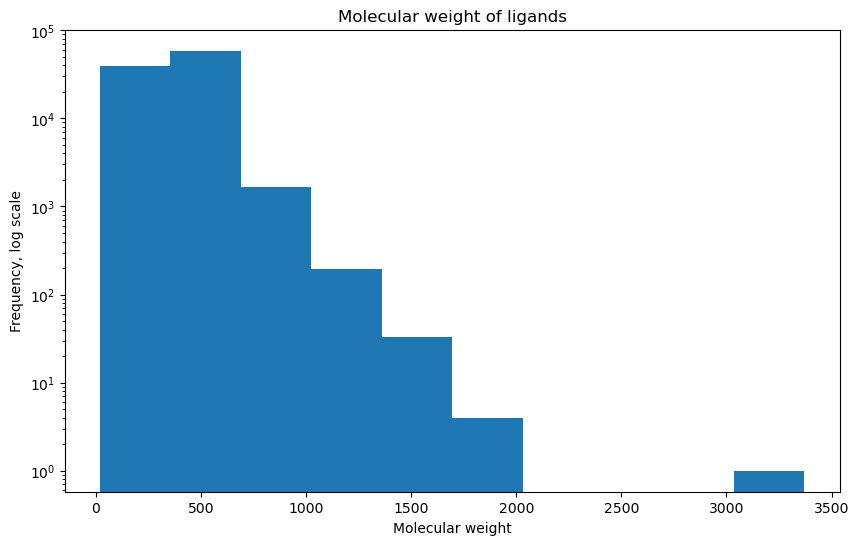

In [23]:
# 1. Molecular weight
molecular_weights = []

for molecule in df_subset['RDKIT Molecules']:
    start_time = time.time()
    mw = Descriptors.MolWt(molecule)   
    molecular_weights.append(mw) 
    end_time = time.time()
    execution_times.append(end_time - start_time)

# Calculer les statistiques
mean_time = np.mean(execution_times)
std_time = np.std(execution_times)

print(f"Mean execution time: {mean_time} seconds")
print(f"Standard deviation: {std_time} seconds")
print(f"Estimation for the full dataset: {round(len(df_bindingDB)*mean_time/60)} minutes")

# Plot
molecular_weights = pd.Series(molecular_weights)

plt.figure(figsize=(10, 6))
molecular_weights.plot(kind = 'hist', logy=True)
plt.xlabel('Molecular weight')
plt.ylabel('Frequency, log scale')
plt.title('Molecular weight of ligands')
plt.show()

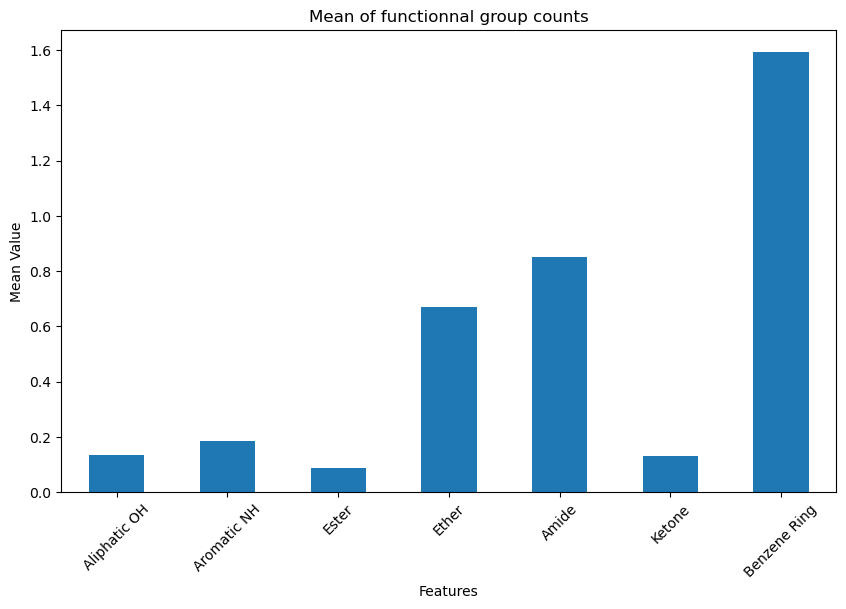

In [20]:
# 2. Functionnal group counts 

# Example SMILES list from your DataFrame
smiles_list = df_subset['Ligand SMILES']  # Assuming ligands_subset is a DataFrame

# Calculate functional group counts for each molecule
results = []
for smiles in smiles_list:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        counts = {
            "SMILES": smiles,
            "Aliphatic OH": Fragments.fr_Al_OH(molecule),
            "Aromatic NH": Fragments.fr_Ar_NH(molecule),
            "Ester": Fragments.fr_ester(molecule),
            "Ether": Fragments.fr_ether(molecule),
            "Amide": Fragments.fr_amide(molecule),
            "Ketone": Fragments.fr_ketone(molecule),
            "Benzene Ring": Fragments.fr_benzene(molecule),
            # Add additional groups as desired
        }
        results.append(counts)

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.set_index('SMILES', inplace=True)
df_results.head()

# Plot 
column_means = df_results.mean()

plt.figure(figsize=(10, 6))
column_means.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Mean of functionnal group counts')
plt.xticks(rotation=45)
plt.show()

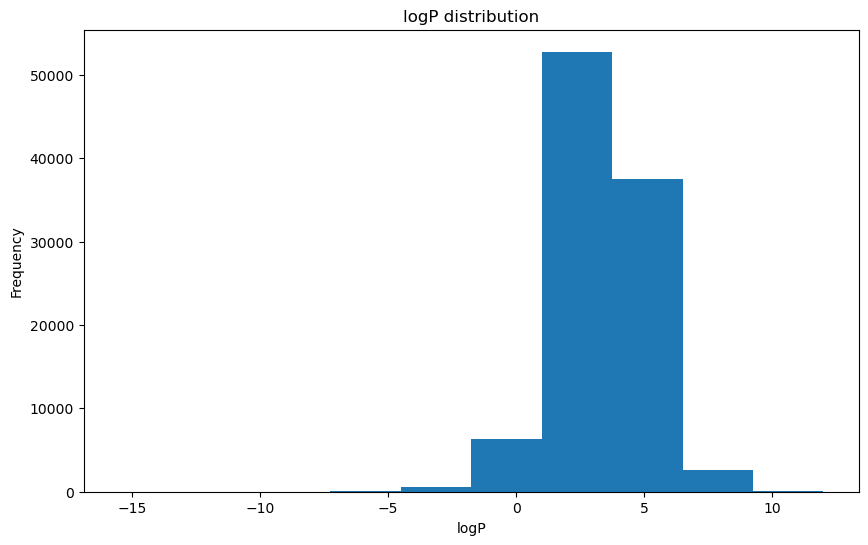

In [21]:
# 3. Hydrophobicity
df_subset['logP'] = [Descriptors.MolLogP(molecule) for molecule in df_subset['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_subset['logP'].plot(kind='hist')
plt.xlabel('logP')
plt.ylabel('Frequency')
plt.title('logP distribution')
plt.show()

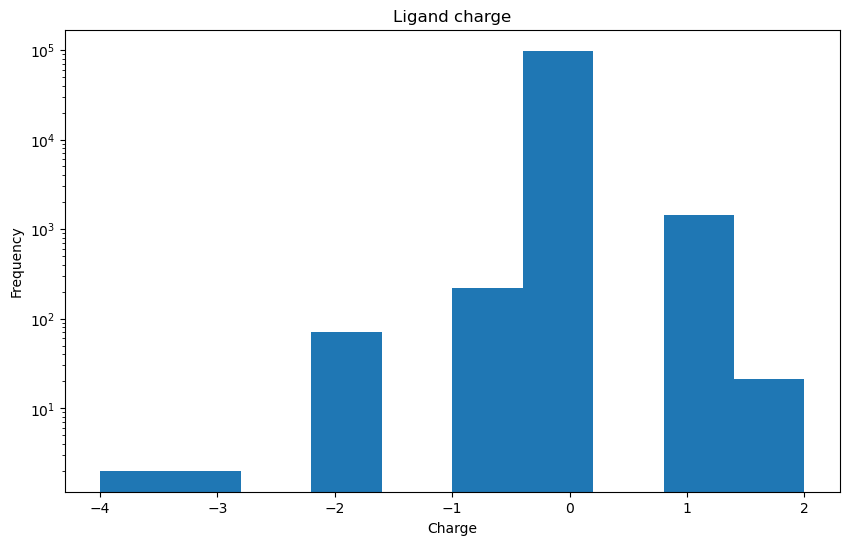

In [ ]:
# 4. Charge
df_subset['Charge'] = [Chem.GetFormalCharge(molecule) for molecule in df_subset['RDKIT Molecules']]

plt.figure(figsize=(10, 6))
df_subset['Charge'].plot(kind='hist', logy=True)
plt.xlabel('Charge')
plt.ylabel('Frequency, log scale')
plt.title('Ligand charge')
plt.show()

**Conclusion** \
Rdkit allow us to have more information about the ligans and caraterize them better, apparently most of the data are compatible with the tool, but it will require an additionnal selection of the sample that we will use.

#### 1.2 Reaction information 

In [95]:
# The affinity measurement are not to heavy to handle lets do the analysis over the all dataset
reaction_metrics = df_bindingDB.iloc[:, 8:16].copy()

In [96]:
for i in range(reaction_metrics.shape[1]) :
    explore_column(reaction_metrics, i)
    print()

# Ki (nM)
2321136 nan values (79.68%)
27546 unique values

# IC50 (nM)
967589 nan values (33.22%)
59209 unique values

# Kd (nM)
2802216 nan values (96.2%)
8074 unique values

# EC50 (nM)
2645258 nan values (90.81%)
23237 unique values

# kon (M-1-s-1)
2912034 nan values (99.97%)
662 unique values

# koff (s-1)
2912054 nan values (99.97%)
578 unique values

# pH
2697779 nan values (92.61%)
88 unique values

# Temp (C)
2712135 nan values (93.1%)
59 unique values



In [97]:
# Among the metrics some of them are string, float : lets clean them 
for col in reaction_metrics.columns[:-2] :
    reaction_metrics[col] = clean_metrics(reaction_metrics[col])
    # Check if its only float: 
    for metric in reaction_metrics[col].unique():
        if type(metric) != np.float64 :
            print(col, type(metric))


In [98]:
# If we remove all the nan value at this step we will not have any metrics left 
print('Sample size with no nan value :', reaction_metrics.dropna().shape[0])

# But lets see how much data we have for each 
print('Individually we have : ')
for col in reaction_metrics.columns :
    col_no_nan = reaction_metrics[col].dropna()
    print(col, col_no_nan.shape[0])

Sample size with no nan value : 0
Individually we have : 
Ki (nM) 506521
IC50 (nM) 1540239
Kd (nM) 54450
EC50 (nM) 195226
kon (M-1-s-1) 83
koff (s-1) 46
pH 215261
Temp (C) 200905


Number of sample with pH information 215261


Text(0.5, 1.0, 'pH distribution in logscale')

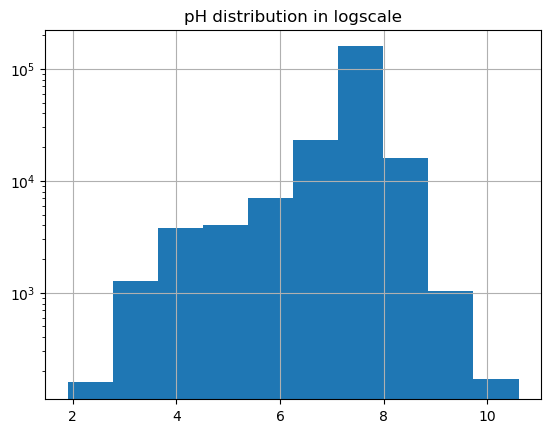

In [99]:
# lets check the pH information
nb = reaction_metrics['pH'].dropna().shape[0]
print('Number of sample with pH information', nb)

reaction_metrics['pH'].dropna().hist(log=True)
plt.title('pH distribution in logscale')

Number of sample with temperature information 200905


Text(0.5, 1.0, 'Temperature distribution in logscale')

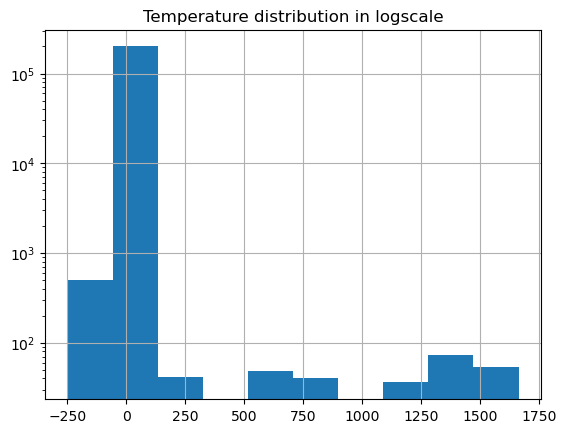

In [100]:
# lets check the temperature information
nb = reaction_metrics['Temp (C)'].dropna().shape[0]
print('Number of sample with temperature information', nb)

# Need to be clean (remove C and to float)
reaction_metrics['Temp (C)'] = clean_metrics(reaction_metrics['Temp (C)'])

reaction_metrics['Temp (C)'].dropna().hist(log=True)
plt.title('Temperature distribution in logscale')

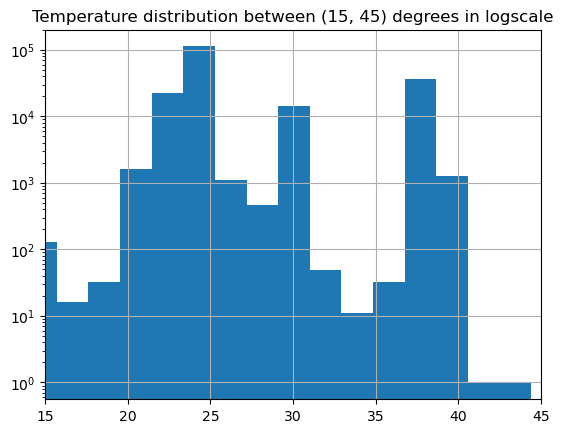

In [101]:
# Closer look to the physiolocial level
reaction_metrics['Temp (C)'].dropna().hist(log=True, bins=1000)
plt.xlim(15,45)
plt.title('Temperature distribution between (15, 45) degrees in logscale')
plt.show()

*REMARQUES:*
For pH and Temperature, lot of value around the human physiological Temp ~ 37 °C and pH =7 and in vitro experiments Temp ~25 °C. Can be intresting to affine our analysis. But not enought data to incorporate it to a model.

In [102]:
# We don't have all the metrics for 1 sample but we do have sample with multiple metrics
commun_pairs= pd.DataFrame(index = reaction_metrics.columns, columns=reaction_metrics.columns)

from itertools import combinations

for i, j in combinations(reaction_metrics.columns, 2) : 
    commun_pairs.at[i, j]= reaction_metrics[[i, j]].dropna().shape[0]


# put on the diagonal the number of sample for 1 metric
for col in reaction_metrics.columns :
    commun_pairs.at[col, col] = reaction_metrics[col].dropna().shape[0]

commun_pairs

,Ki (nM),IC50 (nM),Kd (nM),EC50 (nM),kon (M-1-s-1),koff (s-1),pH,Temp (C)
Ki (nM),506521,2857,13,787,0,1,34971,30354
IC50 (nM),NaN,1540239,110,1218,0,0,142514,129527
Kd (nM),NaN,NaN,54450,11,0,0,2019,1189
EC50 (nM),NaN,NaN,NaN,195226,0,0,6423,11667
kon (M-1-s-1),NaN,NaN,NaN,NaN,83,0,0,0
koff (s-1),NaN,NaN,NaN,NaN,NaN,46,11,8
pH,NaN,NaN,NaN,NaN,NaN,NaN,215261,129990
Temp (C),NaN,NaN,NaN,NaN,NaN,NaN,NaN,200905


In [103]:
# Let's try the trio 
trio = pd.DataFrame()

for i, j, k in combinations(reaction_metrics.columns, 3) : 
    nb = reaction_metrics[[i, j, k]].dropna().shape[0]
    
    if nb != 0 : 
        df = pd.DataFrame([[i, j, k, nb]])
        
        trio = pd.concat([trio, df])
        
trio.columns = [1, 2, 3, 'number']
trio

,1,2,3,number
0,Ki (nM),IC50 (nM),Kd (nM),8
0,Ki (nM),IC50 (nM),EC50 (nM),71
0,Ki (nM),IC50 (nM),pH,1443
0,Ki (nM),IC50 (nM),Temp (C),1399
0,Ki (nM),Kd (nM),pH,8
0,Ki (nM),Kd (nM),Temp (C),8
0,Ki (nM),EC50 (nM),pH,462
0,Ki (nM),EC50 (nM),Temp (C),397
0,Ki (nM),pH,Temp (C),22004
0,IC50 (nM),Kd (nM),pH,66


**Conclusion** \
Juste by looking at the number of data, we can say that a very nice choice could be either IC50 (1540239 samples) or Ki (506521 samples). Additionnaly both have information about temperature and pH : Ki : 22004 sample, IC50 84647 which can allow us to push further the analysis. \

Lets give some chemical theory to see what does this metrics give us about the reaction caracterization. \

*IC50*
- Half maximal inhibitory concentration,  effectiveness of a substance in inhibiting. 
- Concentration of a ligan that is required to inhibit 50% of a target's activity in a particular assay.
- Quantitative measure of how effective an inhibitor is.

*Ki*
- Inhibition constant, concentration of an inhibitor needed to decrease the enzyme's activity to half of its maximum rate when substrate concentration is high.
- Measures the binding affinity between the enzyme and the inhibitor (lower Ki values indicate stronger inhibition)
- Used in Michaelis-Menten kinetics to understand competitive, non-competitive, and uncompetitive inhibition.


*Relationship IC50 - Ki* : IC50 used in practical applications to assess inhibitor strength, depends on the concentrations. Ki is more specific to the interaction between the enzyme and the inhibitor. 


We will go for Ki that seems more suited to study the overall structrual properties associated to ligan-target binding.

#### 1.3 Target information

In [ ]:
for i in range(16, len(df_subset.columns)) :
    explore_column(df_subset, i)
    print()

# Data cleaning 

- select the family of interest
- select the exp of interest (metric dependant)
- select the ligan that are Rdkit compatible